# Symforce

## Introduction

[SymForce](https://symforce.org/) is a fast symbolic computation and code generation library for robotics applications like computer vision, state estimation, motion planning, and controls. It combines the development speed and flexibility of symbolic mathematics with the performance of autogenerated, highly optimized code in C++ or any target runtime language. SymForce contains three independently useful systems:

**Symbolic Toolkit** - builds on the SymPy API to provide rigorous geometric and camera types, lie group calculus, singularity handling, and tools to model complex problems

**Code Generator** - transforms symbolic expressions into blazing-fast, branchless code with clean APIs and minimal dependencies, with a template system to target any language

**Optimization Library** - a fast tangent-space optimization library based on factor graphs, with a highly optimized implementation for real-time robotics applications

SymForce automatically computes tangent space Jacobians, eliminating the need for any bug-prone handwritten derivatives. Generated functions can be directly used as factors in our nonlinear optimizer. This workflow enables faster runtime functions, faster development time, and fewer lines of handwritten code versus alternative methods.

SymForce is developed and maintained by **Skydio**. It is used in production to accelerate tasks like SLAM, bundle adjustment, calibration, and sparse nonlinear MPC for autonomous robots at scale.

## Tutorials

In [1]:
# Import symforce
import symforce

symforce.set_symbolic_api("sympy")
symforce.set_log_level("warning")

import symforce.symbolic as sf
#

### Geo Package

#### Matrix

In [ ]:
# Define matrix
import symforce.symbolic as sf
from symforce.notebook_util import display

# Construction from 2D list
m1 = sf.Matrix([[1, 2, 3], [4, 5, 6]])
print(m1.shape)

# Construction using specified size + data
m2 = sf.Matrix(2, 3, [1, 2, 3, 4, 5, 6])
print(m2.shape)

# Construction from 2D list
v1 = sf.Matrix([[1], [2], [3]])
print(v1.shape)

# Construction from 1D list. We assume a 1D list represents a column vector.
v2 = sf.Matrix([1, 2, 3])
print(v2.shape)

# Construction using aliases (defined by default for 9x1 vectors and smaller)
v3 = sf.V3(1, 2, 3)
print(v3.shape)

zero_matrix = sf.Matrix33.zero()
identity_matrix = sf.Matrix33.eye()

zero_matrix = sf.Matrix.zeros(3,3)
identity_matrix = sf.Matrix.eye(3,3)
#

#### Rotations

Quaternion is used as the underlying representation.

<Rot3 <Q xyzw=[0, 0, 0, 1]>>

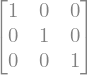

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

<Rot3 <Q xyzw=[R_x, R_y, R_z, R_w]>>

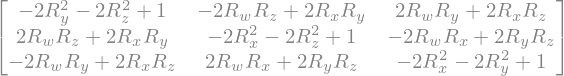

<Q xyzw=[Q_x, Q_y, Q_z, Q_w]>

In [4]:
# Define rotations

import symforce.symbolic as sf
from symforce.notebook_util import display

# Identity definition
R = sf.Rot3()
display(R)
display(R.to_rotation_matrix())
display(R.to_rotation_matrix().to_numpy())

# Symbolic definition
R_sym = sf.Rot3.symbolic("R")
display(R_sym)
display(R_sym.to_rotation_matrix())

# Symbolic definition
Q_sym = sf.Quaternion.symbolic("Q")
display(Q_sym)
#

#### symforce.symbolic.Pose3 and  sym.Pose3

SymForce provides **sym** packages with **runtime code** for geometry and camera types, e.g. `sym.Pose3` that are generated from its **symbolic geo and cam packages**, e.g. `symforce.symbolic.Pose3`. As such, there are multiple versions of a class like Pose3 and it can be a common source of confusion.

In [2]:
# symforce.symbolic
import symforce.symbolic as sf
from symforce.notebook_util import display
q = sf.Quaternion(xyz = sf.V3(0.0, 0.0, 0.0), w=sf.Scalar(1.0))
R = sf.Rot3(q)
t = sf.V3(0.0, 0.0, 0.0)
T = sf.Pose3(R, t)
display(T)
#

<Pose3 R=<Rot3 <Q xyzw=[0, 0, 0, 1.0]>>, t=(0, 0, 0)>

In [119]:
# sym runtime code
import sym
import symforce.symbolic as sf
print(f"sym package rotation matrix type: {type(sym.Pose3.identity().R.to_rotation_matrix())}")
print(f"symbolic package rotation matrix type: {type(sf.Pose3.identity().R.to_rotation_matrix())}")
print(f"symbolic package rotation matrix to_numpy type: { type(sf.Pose3.identity().R.to_rotation_matrix().to_numpy())}")

sym package rotation matrix type: <class 'numpy.ndarray'>
symbolic package rotation matrix type: <class 'symforce.geo.matrix.Matrix33'>
symbolic package rotation matrix to_numpy type: <class 'numpy.ndarray'>


In [ ]:
# k3d plot helper

import k3d
import math
import numpy as np
import time

# TODO(xipeng.wang): Update this to use symforce directly instead of numpy
class XYZ_RBG_Axes():
    def __init__(self, plot, name, R, t, color=0xffff00, axis_length = 1):
        self.axis_length = axis_length
        self.plot = plot
        self.R = R
        self.t = t.reshape(3, 1)
        self.name = name
        origin = self.t
        x_axis = np.stack((origin, origin + self.R.dot(np.array([axis_length, 0., 0.])).reshape(3,1)), axis=0)
        y_axis = np.stack((origin, origin + self.R.dot(np.array([0., axis_length, 0.])).reshape(3,1)), axis=0)
        z_axis = np.stack((origin, origin + self.R.dot(np.array([0., 0., axis_length])).reshape(3,1)), axis=0)
        self.xline_plot = k3d.line(x_axis, shader='mesh', width=0.05, color=0xff0000, name=name+'_xaxis')
        self.yline_plot = k3d.line(y_axis, shader='mesh', width=0.05, color=0x0000ff, name=name+'_yaxis')
        self.zline_plot = k3d.line(z_axis, shader='mesh', width=0.05, color=0x00ff00, name=name+'_zaxis')
        self.xpoint = k3d.points(origin + self.R.dot(np.array([axis_length, 0., 0.])).reshape(3,1), point_size=0.3, 
                                  shader='3d', color=color, name=self.name+'_end_point_x')
        self.ypoint = k3d.points(origin + self.R.dot(np.array([0., axis_length, 0.])).reshape(3,1), point_size=0.3, 
                                  shader='3d', color=color, name=self.name+'_end_point_y')
        self.zpoint = k3d.points(origin + self.R.dot(np.array([0., 0., axis_length])).reshape(3,1), point_size=0.3, 
                                  shader='3d', color=color, name=self.name+'_end_point_z')
        self.plot += self.xline_plot
        self.plot += self.yline_plot
        self.plot += self.zline_plot
        self.plot += self.xpoint
        self.plot += self.ypoint
        self.plot += self.zpoint 
    def update_pose(self, R, t):
        self.R = R
        self.t = t.reshape(3,1)
        origin = self.t
        axis_length = self.axis_length
        x_axis = np.stack((origin, origin + self.R.dot(np.array([axis_length, 0., 0.])).reshape(3,1)), axis=0)
        y_axis = np.stack((origin, origin + self.R.dot(np.array([0., axis_length, 0.])).reshape(3,1)), axis=0)
        z_axis = np.stack((origin, origin + self.R.dot(np.array([0., 0., axis_length])).reshape(3,1)), axis=0)
        self.xline_plot.vertices = x_axis
        self.xpoint.positions = origin + self.R.dot(np.array([axis_length, 0., 0.])).reshape(3,1)
        self.yline_plot.vertices = y_axis
        self.ypoint.positions = origin + self.R.dot(np.array([0., axis_length, 0.])).reshape(3,1)
        self.zline_plot.vertices = z_axis
        self.zpoint.positions = origin + self.R.dot(np.array([0., 0., axis_length])).reshape(3,1)
#

In [ ]:
# k3d plot example

plot = k3d.plot(camera_auto_fit=True, grid=(0, 0, 0, 5, 5, 5))

R = sf.Rot3().to_rotation_matrix().to_numpy()
t = sf.V3(0, 0, 0).to_numpy()
C0 = XYZ_RBG_Axes(plot, 'C0', R, t)

R = sf.Rot3.random().to_rotation_matrix().to_numpy()
t = sf.V3(1, 0, 0).to_numpy()
C1 = XYZ_RBG_Axes(plot, 'C1', R, t)

plot.display()

#

 ### Values
 
Values objects are ordered dict-like containers used to store multiple heterogeneous objects, normally for the purpose of function generation.

In [106]:
# Create Values

import symforce.symbolic as sf
from symforce.values import Values
from symforce.notebook_util import display

inputs = Values(
    x=sf.Symbol("x"),
    y=sf.Symbol("y")
)
inputs.add(sf.Symbol("z"))

time = Values(
    {"h": sf.Symbol("h"),
     "m": sf.Symbol("m"),
     "s": sf.Symbol("s")
    }
)

timezone = Values(time_zone=sf.Symbol("zone"))
# time["t"] =  time
inputs["t"] =  time
time["timezone"] =  timezone
inputs.add("id")

display(inputs)

# A Values serializes to a depth-first traversed list.
# display(inputs.to_storage())

display(inputs.items_recursive())
# display(inputs.keys_recursive())
# display(inputs.values_recursive())

# Index describes which parts of the serialized list correspond to which types. 
# The spec is T.Dict[str, IndexEntry] where IndexEntry has attributes 
# offset, storage_dim, datatype, shape, item_index
index = inputs.index()
reconstructed_inputs = Values.from_storage_index(inputs.to_storage(), index)
assert inputs == reconstructed_inputs

print(f'Before modifying id: {inputs["id"]}')
inputs["id"] = 1024
inputs.attr.id = 1024
print(f'After modifying id: {inputs["id"]}')

#

Values(
  x: x,
  y: y,
  z: z,
  t:   Values(
    h: h,
    m: m,
    s: s,
    timezone:     Values(
      time_zone: zone,
    ),
  ),
  id: id,
)

[('x', x),
 ('y', y),
 ('z', z),
 ('t.h', h),
 ('t.m', m),
 ('t.s', s),
 ('t.timezone.time_zone', zone),
 ('id', id)]

Before modifying id: id
After modifying id: 1024


In [107]:
# Use scope to add sub-values
with sf.scope("foo"):
    inputs.add(sf.Symbol("x"))
    with sf.scope("bar"):
        inputs.add(sf.Symbol("x"))
        inputs.add(sf.Symbol("y"))
inputs.attr.foo.bar.z = sf.Symbol("z")
# This attr can also be used to add new values
inputs.attr.foo.bar.x = 1024

with inputs.scope("foo2"):
    inputs["x"] = sf.Symbol("x")
with inputs["foo2"].scope("bar2"):
    inputs["foo2"]["x"] = sf.Symbol("x")

display(inputs)
display(inputs.items_recursive())
#

Values(
  x: x,
  y: y,
  z: z,
  t:   Values(
    h: h,
    m: m,
    s: s,
    timezone:     Values(
      time_zone: zone,
    ),
  ),
  id: 1024,
  foo:   Values(
    x: foo.x,
    bar:     Values(
      x: 1024,
      y: foo.bar.y,
      z: z,
    ),
  ),
  foo2:   Values(
    x: foo2.x,
    bar2:     Values(
      x: bar2.x,
    ),
  ),
)

[('x', x),
 ('y', y),
 ('z', z),
 ('t.h', h),
 ('t.m', m),
 ('t.s', s),
 ('t.timezone.time_zone', zone),
 ('id', 1024),
 ('foo.x', foo.x),
 ('foo.bar.x', 1024),
 ('foo.bar.y', foo.bar.y),
 ('foo.bar.z', z),
 ('foo2.x', foo2.x),
 ('foo2.bar2.x', bar2.x)]

tangent dim: 6, storage dim: 7
storage_D_tangent shape: (7, 6)


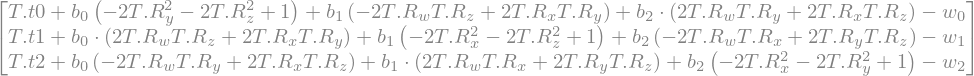

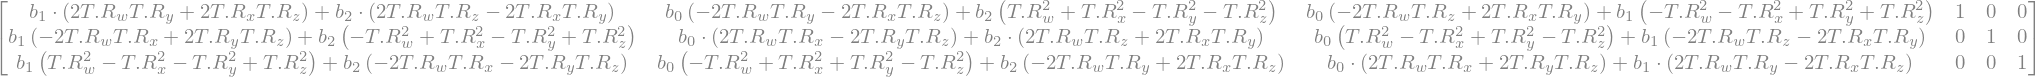

In [118]:
# Group Ops on values
w_T_b = Values(
    T=sf.Pose3.symbolic("T")
)
print(f"tangent dim: {w_T_b.tangent_dim()}, storage dim: {len(w_T_b.to_storage())}")
print(f"storage_D_tangent shape: {w_T_b.storage_D_tangent().shape}")
# display(pose.to_tangent())
p_w = sf.Matrix(3, 1).symbolic("w")
p_b = sf.Matrix(3, 1).symbolic("b")
residual = w_T_b["T"] * p_b - p_w
residual_D_tangent = residual.jacobian(w_T_b["T"])
display(residual)
display(residual_D_tangent.shape)
display(residual_D_tangent)
#

### Ops Package

#### Storage Ops
Data type that can be serialized to and from a vector of scalar quantities.
`.storage_dim()`, `.to_storage()`, `.from_storage()`, `.symbolic()`, `.evalf()`, `.subs()`, `.simplify()`

In [156]:
# Storage Ops

from symforce.ops import StorageOps

# Element-wise operations on Values object with multiple types of elements
values = Values(
    pose=sf.Pose3(),
    scalar=sf.Symbol("x"),
)
print(f"Storage dim: {StorageOps.storage_dim(values)}")  # 4 quaternion + 3 position + 1 scalar

# Serialize geometric type and reconstruct
T = sf.Pose3.symbolic("T")
T_serialized = StorageOps.to_storage(T)
T_recovered = StorageOps.from_storage(sf.Pose3, T_serialized)
display(T_serialized)
assert(T == T_recovered)

Storage dim: 8


#### Group Ops
Mathematical group that implements closure, associativity, identity and invertibility.
Methods: `.identity()`, `.inverse()`, `.compose()`, `.between()`

In [157]:
# Group Ops
from symforce.ops import GroupOps
# Identity of a pose
w_T_b = sf.Pose3()
display(GroupOps.identity(w_T_b))
# Inverse of a vector
p_b = sf.V3(1, 1, 1)
display(GroupOps.inverse(p_b).T)

# Compose a pose and a point (wrong, they are not the same group)
p_w = w_T_b * p_b # GroupOps.compose(w_T_b, p_b)
# display(p_w)
display(GroupOps.compose(p_b, GroupOps.inverse(p_b)).T)

<Pose3 R=<Rot3 <Q xyzw=[0, 0, 0, 1]>>, t=(0, 0, 0)>

In [174]:
# Relative rotation -> b1_R_b2 = GroupOps.between(w_R_b1, w_R_b2)
w_R_b1 = sf.Rot3.from_angle_axis(
    angle=sf.Scalar(0.2),
    axis=sf.V3(0, 1, 2).normalized(),
)
w_R_b2 = sf.Rot3.from_angle_axis(
    angle=sf.Scalar(0.1),
    axis=sf.V3(1, 0, 3).normalized(),
)
b1_R_b2 = GroupOps.between(w_R_b1, w_R_b2)
display(w_R_b2)
display(GroupOps.simplify(GroupOps.compose(w_R_b1, b1_R_b2)))

<Rot3 <Q xyzw=[0.00499791692706783*sqrt(10), 0, 0.0149937507812035*sqrt(10), 0.998750260394966]>>

<Rot3 <Q xyzw=[0.00499791692706783*sqrt(10), 0, 0.0149937507812035*sqrt(10), 0.998750260394966]>>

#### Lie Group Ops
Group that is also a differentiable manifold, e.g. SO3, SE3.
Methods: `.tangent_dim()`, `.from_tangent()`, `to_tangent()`, `.retract()`, `.local_coordinates()`, `.storage_D_tangent()`

3D rotation tangent space: 3


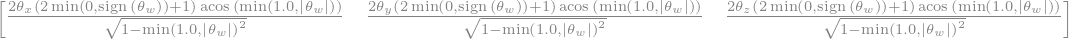

In [220]:
# Lie Group Ops: basics
from symforce.ops import LieGroupOps
R = sf.Rot3.symbolic('theta')
# Underlying dimension of a 3D rotation's tangent space
print(f"3D rotation tangent space: {LieGroupOps.tangent_dim(R)}")
R_tangent = sf.V3(LieGroupOps.to_tangent(R))
display(R_tangent.T)
R_reconstruct_ = sf.Rot3.from_angle_axis(R_tangent.norm(), R_tangent.normalized())
R_reconstruct = LieGroupOps.from_tangent(sf.Rot3, R_tangent)
assert R_reconstruct_ == R_reconstruct

In [219]:
# Lie Group Ops, retract: R_perturbed = R * delta_R, local_coordinates: delta_R = R.inv() * R_perturbed

# Retract perturbs the given element in the tangent space and returns the updated element
R = sf.Rot3.from_yaw_pitch_roll(0, 0, 1)
R_tangent_delta = sf.V3(0, 0, 0.1)
R_perturbed = LieGroupOps.retract(R, R_tangent_delta)
# Local coordinates compute the tangent space perturbation between one element and another
R_tangent_delta_reconstruct = LieGroupOps.local_coordinates(R, R_perturbed)
display(R_tangent_delta.T)
display(R_tangent_delta_reconstruct)

### Geo Package Ops Operations

#### Geo Storage Operations

In [228]:
# Geo Storage Operations
rot = sf.Rot3()
elements = rot.to_storage()
print("Symbolic to_storage test:")
assert len(elements) == rot.storage_dim()
display(elements)
# Construction from scalar list
rot2 = sf.Rot3.from_storage(elements)
assert rot == rot2
# Symbolic operations
print("Symbolic subs test:")
rot_sym = sf.Rot3.symbolic("rot_sym")
rot_num = rot_sym.subs(rot_sym, rot)

display(rot_sym)
display(rot_num)
display(rot_num.simplify())  # Simplify internal symbolic expressions
display(rot_num.evalf())  # Numerical evaluation
#

Symbolic to_storage test:


Symbolic subs test:


<Rot3 <Q xyzw=[rot_sym_x, rot_sym_y, rot_sym_z, rot_sym_w]>>

<Rot3 <Q xyzw=[0, 0, 0, 1]>>

<Rot3 <Q xyzw=[0, 0, 0, 1]>>

<Rot3 <Q xyzw=[0, 0, 0, 1.00000000000000]>>

#### Geo Group Operations

In [226]:
# Geo Group Operations
R1 = sf.Rot3.random()
R2 = sf.Rot3.random()

# Composition
print("Composition test:")
display(R1.compose(R2))  # For rotations this is the same as R1 * R2
# Identity
print("Identity test:")
R_identity = sf.Rot3.identity()
display(R1)
display(R_identity * R1)
# Inverse
print("Inverse test:")
R1_inv = R1.inverse()
display(R_identity)
display(R1_inv * R1)
# Between
print("Between test:")
R_delta = R1.between(R2)
display(R1 * R_delta)
display(R2)
#

Composition test:


<Rot3 <Q xyzw=[0.653650322359889, -0.691680810177783, -0.212217870334203, -0.221996595517666]>>

Identity test:


<Rot3 <Q xyzw=[-0.791212654348329, -0.357369165559331, -0.282587404337844, 0.407938934175323]>>

<Rot3 <Q xyzw=[-0.791212654348329, -0.357369165559331, -0.282587404337844, 0.407938934175323]>>

Inverse test:


<Rot3 <Q xyzw=[0, 0, 0, 1]>>

<Rot3 <Q xyzw=[0, 0, 0, 1.00000000000000]>>

Between test:


<Rot3 <Q xyzw=[0.210623061771348, -0.00887545816305885, -0.930166453588175, -0.300581970037551]>>

<Rot3 <Q xyzw=[0.210623061771348, -0.00887545816305891, -0.930166453588175, -0.300581970037551]>>

#### Geo Tangent Operations

In [233]:
# Geo Tangent Operations
# To/From tangent space vector about identity element
print("To/From tangent space vector test:")
R1 = sf.Rot3.random()
tangent_vec = R1.to_tangent()
R1_recovered = sf.Rot3.from_tangent(tangent_vec)

assert len(tangent_vec) == R1.tangent_dim()
display(R1)
display(R1_recovered)

print("Tangent space perturbations test:")
# Tangent space perturbations
# Perturb R1 by the given vector in the tangent space around R1
R_perturb_delta = [0.1, 2.3, -0.5]
R2 = R1.retract(R_perturb_delta)

# Compute the tangent vector pointing from R1 to R2, in the tangent space around R1
recovered_tangent_vec = R1.local_coordinates(R2)
recovered_tangent_vec2 = R1.between(R2).to_tangent()
display(R_perturb_delta)
display(recovered_tangent_vec)
display(recovered_tangent_vec2)

jacobian = R1.storage_D_tangent()
assert jacobian.shape == (R1.storage_dim(), R1.tangent_dim())
#

To/From tangent space vector test:


<Rot3 <Q xyzw=[0.205544235406664, -0.0361582276632704, -0.977639522350119, -0.0257898081104291]>>

<Rot3 <Q xyzw=[-0.205544235406664, 0.0361582276632704, 0.977639522350119, 0.0257898081104292]>>

Tangent space perturbations test:


#### Special SE(n)
Perturbation on SE(3) is done separately on SO(3) and R(3).
```
Pose3(R=self.R.retract(vec[:3], epsilon=epsilon),
t=ops.LieGroupOps.retract(self.t, vec[3:], epsilon=epsilon))
```

In [259]:
# SE(n)
T = sf.Pose3(sf.Rot3.random(), sf.V3(0, 0, 1))
display(T)
T_tangent_delta = [0.1, 0.1, 0.1, 0.1, 0, 0.1]
T_perturb = T.retract(T_tangent_delta)
display(T_perturb)
T_perturb_reconstruct =  T.compose(sf.Pose3.from_tangent(T_tangent_delta))
display(T_perturb_reconstruct)
assert T_perturb_reconstruct != T_perturb # This is expected since SE(3) is modeled as SO(3) + R(3)
T_perturb_reconstruct = sf.Pose3(T.rotation().compose(sf.Rot3.from_tangent(T_tangent_delta[0:3])), 
                                             T.t + sf.V3(T_tangent_delta[3:]))
assert T_perturb_reconstruct == T_perturb
display(T_perturb_reconstruct)

<Pose3 R=<Rot3 <Q xyzw=[-0.786164569658020, -0.406853477120950, -0.308209471241873, -0.348457227512671]>>, t=(0, 0, 1)>

<Pose3 R=<Rot3 <Q xyzw=[-0.805545422953996, -0.398861926943418, -0.343397355446605, -0.272183745042075]>>, t=(0.100000000000000, 0, 1.10000000000000)>

<Pose3 R=<Rot3 <Q xyzw=[-0.805545422953996, -0.398861926943418, -0.343397355446605, -0.272183745042075]>>, t=(0.124710314191249, 0.0557405950682781, 0.963389569850190)>

<Pose3 R=<Rot3 <Q xyzw=[-0.805545422953996, -0.398861926943418, -0.343397355446605, -0.272183745042075]>>, t=(0.100000000000000, 0, 1.10000000000000)>

## Solve Problems in Real World